# Import & Combine Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load credits.csv
credits = pd.read_csv('./raw-data/credits.csv')

# Load keywords.csv
keywords = pd.read_csv('./raw-data/keywords.csv')

# Load links.csv
links = pd.read_csv('./raw-data/links.csv')

# Load movies_metadata.csv
movies_metadata = pd.read_csv('./raw-data/movies_metadata.csv', low_memory=False)

# Load ratings.csv
ratings = pd.read_csv('./raw-data/ratings.csv')

In [3]:
# Function to safely parse JSON-like strings
def parse_json_column(df, column_name):
    def parse_json(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except:
            return []
    df[column_name] = df[column_name].apply(parse_json)
    return df

In [4]:
# Parse columns in credits dataframe
credits = parse_json_column(credits, 'cast')
credits = parse_json_column(credits, 'crew')

# Parse keywords dataframe
keywords = parse_json_column(keywords, 'keywords')

# Parse columns in movies_metadata dataframe
json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection']
for column in json_columns:
    movies_metadata = parse_json_column(movies_metadata, column)

In [5]:
# Convert numeric columns to appropriate data types
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce')
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

In [6]:
# Merge credits and movies_metadata on 'id'
df = movies_metadata.merge(credits, on='id')

# Merge keywords
df = df.merge(keywords, on='id')

# EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  46628 non-null  object        
 1   belongs_to_collection  46628 non-null  object        
 2   budget                 46628 non-null  float64       
 3   genres                 46628 non-null  object        
 4   homepage               8009 non-null   object        
 5   id                     46628 non-null  float64       
 6   imdb_id                46611 non-null  object        
 7   original_language      46617 non-null  object        
 8   original_title         46628 non-null  object        
 9   overview               45633 non-null  object        
 10  popularity             46624 non-null  object        
 11  poster_path            46229 non-null  object        
 12  production_companies   46628 non-null  object        
 13  p

In [8]:
# Check for missing values
df.isnull().sum()

adult                        0
belongs_to_collection        0
budget                       0
genres                       0
homepage                 38619
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   995
popularity                   4
poster_path                399
production_companies         0
production_countries         0
release_date                88
revenue                      4
runtime                    268
spoken_languages             0
status                      86
tagline                  25845
title                        4
video                        4
vote_average                 4
vote_count                   4
cast                         0
crew                         0
keywords                     0
dtype: int64

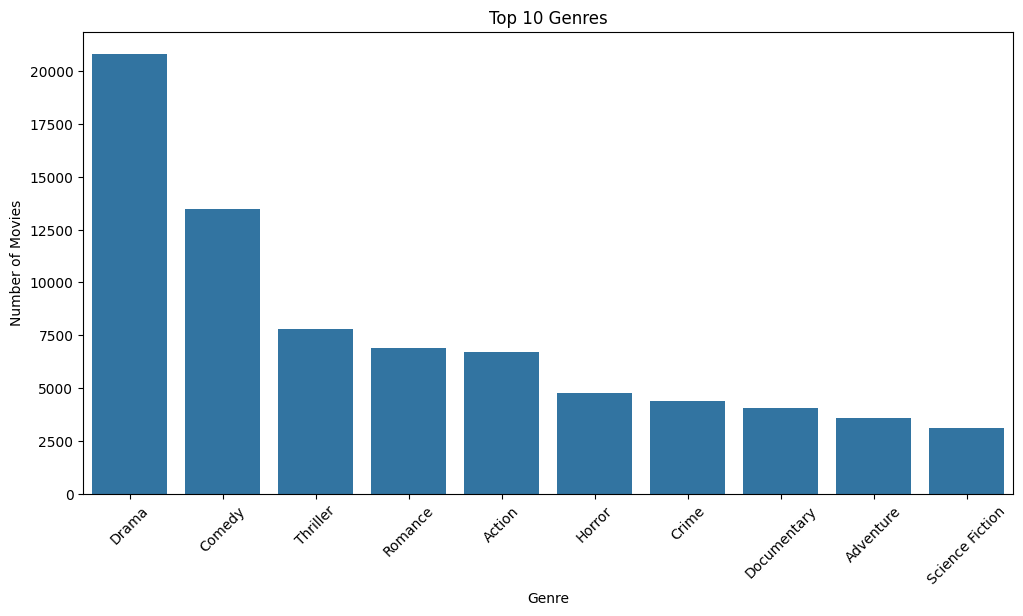

In [9]:
# Function to extract names from lists of dictionaries
def get_names(x):
    return [d['name'] for d in x] if isinstance(x, list) else []

# Extract genres
df['genres_list'] = df['genres'].apply(get_names)

# Explode genres for analysis
genres_exploded = df.explode('genres_list')

# Count of each genre
genre_counts = genres_exploded['genres_list'].value_counts()

# Plot top genres
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10])
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

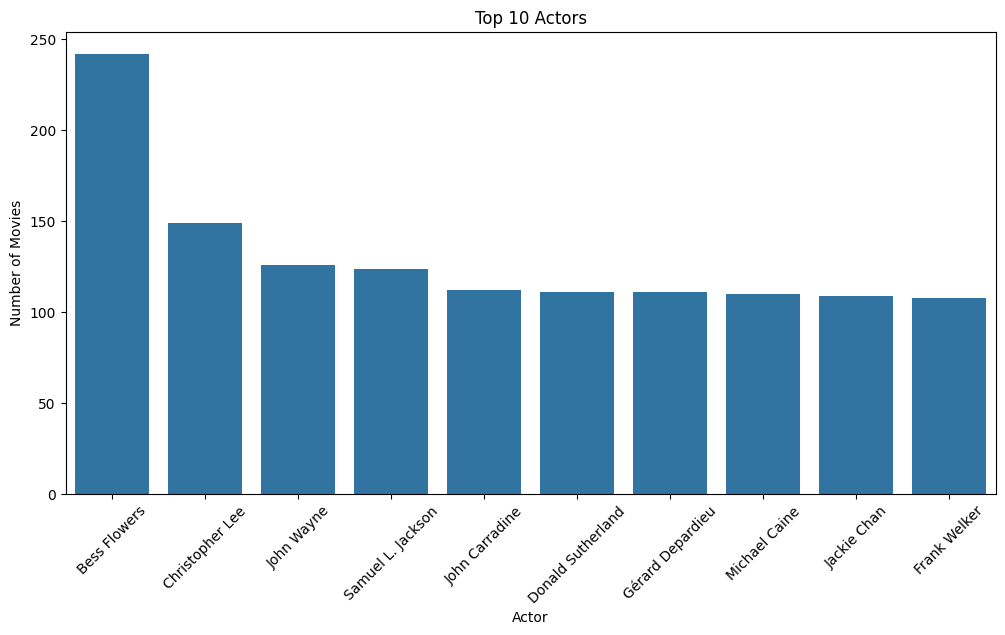

In [10]:
# Extract cast names
df['cast_list'] = df['cast'].apply(get_names)

# Explode cast list for analysis
cast_exploded = df.explode('cast_list')

# Count of each actor
cast_counts = cast_exploded['cast_list'].value_counts()

# Plot top actors
plt.figure(figsize=(12,6))
sns.barplot(x=cast_counts.index[:10], y=cast_counts.values[:10])
plt.title('Top 10 Actors')
plt.xlabel('Actor')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

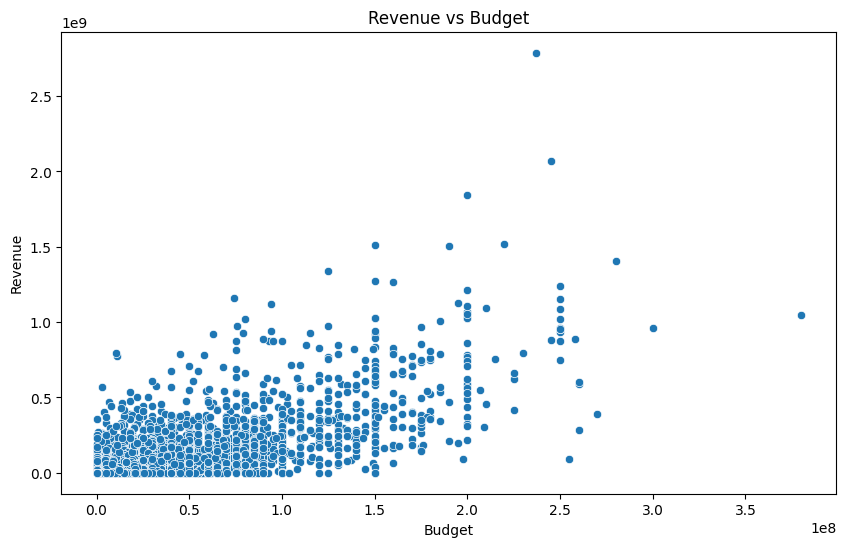

In [11]:
# Scatter plot of Revenue vs Budget
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='budget', y='revenue')
plt.title('Revenue vs Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

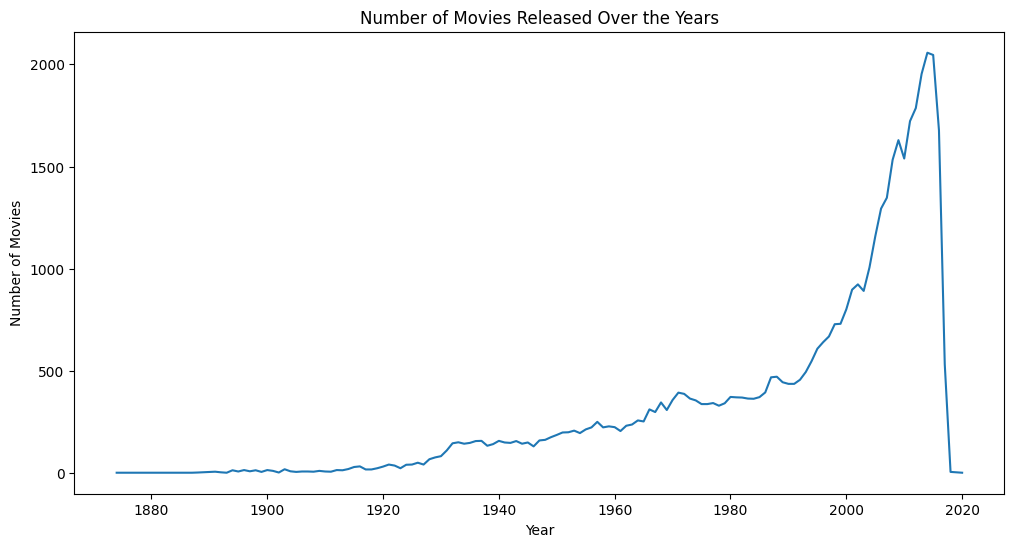

In [12]:
# Extract release year
df['release_year'] = df['release_date'].dt.year

# Movies per year
movies_per_year = df['release_year'].value_counts().sort_index()

# Plot the trend
plt.figure(figsize=(12,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

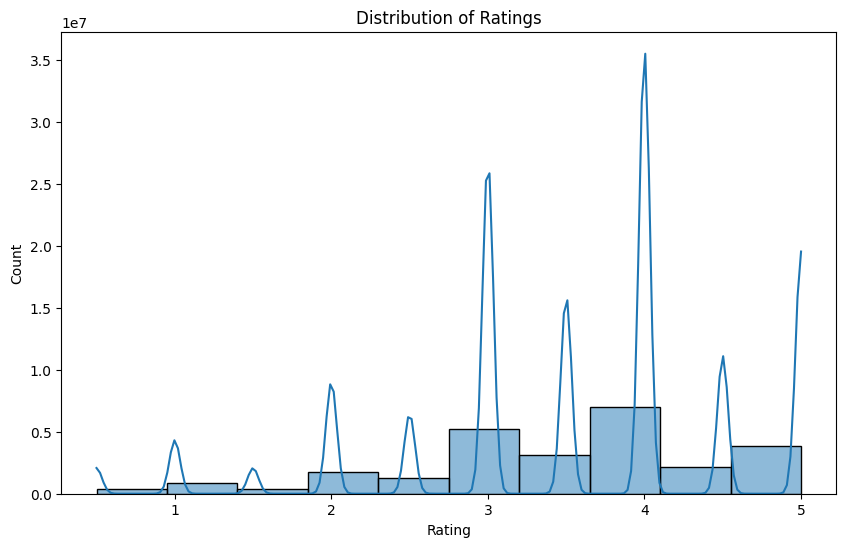

In [13]:
# Convert 'movieId' in ratings to numeric
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')

# Merge ratings with links to map 'movieId' to 'tmdbId'
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce')
df_links = df.merge(links, left_on='id', right_on='tmdbId')

# Merge with ratings
df_ratings = df_links.merge(ratings, on='movieId')

# Average rating per movie
average_ratings = df_ratings.groupby('title')['rating'].mean().sort_values(ascending=False)

# Distribution of ratings
plt.figure(figsize=(10,6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()